In [3]:
from cProfile import label

import pandas as pd
import chardet
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
from matplotlib.ticker import PercentFormatter
from networkx.algorithms.bipartite.basic import color
from scipy import stats
import openpyxl
from ydata_profiling import ProfileReport


F:\anaconda\envs\data_analysis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [130]:
# 检测数据类型
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
    return result['encoding']

In [131]:
# 加载数据
print("1. 加载数据")
try:
    encoding = detect_encoding('data/score.csv')
    df = pd.read_csv('data/score.csv', sep=',', encoding=encoding)
    print(f"加载成功！共有{len(df)}条数据。")

except Exception as e:
    print(f"加载错误:{e}")
    exit()


1. 加载数据
加载成功！共有77条数据。


In [132]:
# 数据初始化
print("2. 数据初始诊断")
print(f"\n数据集形状:{df.shape[0]}行, {df.shape[1]}列")
print("\n前三条记录")
print(df.head(3))
print("\n数据类型和缺失值统计：")
print(df.info())
print("\n缺失值统计：")
print(df.isnull().sum())
print(df.describe())

2. 数据初始诊断

数据集形状:77行, 11列

前三条记录
       fNAME     lNAME  Age  gender country  residence  entryEXAM  \
0  Christina    Binger   44  Female  Norway    Private         72   
1       Alex  Walekhwa   60       M   Kenya    Private         79   
2     Philip       Leo   25    Male  Uganda  Sognsvann         55   

  prevEducation  studyHOURS  Python  DB  
0       Masters         158    59.0  55  
1       Diploma         150    60.0  75  
2    HighSchool         130    74.0  50  

数据类型和缺失值统计：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fNAME          77 non-null     object 
 1   lNAME          77 non-null     object 
 2   Age            77 non-null     int64  
 3   gender         77 non-null     object 
 4   country        77 non-null     object 
 5   residence      77 non-null     object 
 6   entryEXAM      77 non-null     int64  
 7   prevE

In [133]:
# 数据规范化
print("\n3. 文本数据标准化")

def clean_text_data(df):

    # 清理性别
    def clean_gender(text):
        gender_mapper = {
            'Male': 'Male', 'M': 'Male', 'MALE': 'Male',
            'Female': 'Female', 'F': 'Female', 'female': 'Female'
        }
        return gender_mapper.get(str(text).title(), str(text).title())

    #学校清理
    edu_mapping = {
        'Bachelors': 'Bachelors', 'Bachelor': 'Bachelors', 'barchelors': 'Bachelors',
        'Barrrchelors': 'Bachelors', 'HighSchool': 'High School', 'High School': 'High School',
        'Masters': 'Masters', 'Diploma': 'Diploma', 'Doctorate': 'Doctorate'
    }

    # 清理居住地
    def clean_residence(text):
        text = str(text).replace('_', ' ').title()
        if 'Bi' in text and 'Residence' in text:
            return 'BI Residence'
        if text == 'Biresidence':
            return 'BI Residence'
        return text.replace('-', ' ').title()

    # 国家清理
    country_corrections = {
        'Rsa': 'South Africa',
        'South Africa': 'South Africa',
        'Norge': 'Norway',
        'Norway': 'Norway',
        'Kenya': 'Kenya',
        'Uganda': 'Uganda',
        'Somali': 'Somalia',
        'Nigeria': 'Nigeria',
        'England': 'UK',
        'Uk': 'UK',
        'United Kingdom': 'UK'
    }

    df['gender'] = df['gender'].apply(clean_gender)
    df['residence'] = df['residence'].apply(clean_residence)
    df['prevEducation'] = df['prevEducation'].str.title().replace(edu_mapping)
    df['country'] = df['country'].str.title().replace(country_corrections)

    return df

df = clean_text_data(df)

print(df.head(3))


3. 文本数据标准化
       fNAME     lNAME  Age  gender country  residence  entryEXAM  \
0  Christina    Binger   44  Female  Norway    Private         72   
1       Alex  Walekhwa   60    Male   Kenya    Private         79   
2     Philip       Leo   25    Male  Uganda  Sognsvann         55   

  prevEducation  studyHOURS  Python  DB  
0       Masters         158    59.0  55  
1       Diploma         150    60.0  75  
2    Highschool         130    74.0  50  


In [134]:
# 处理缺失值
print("4. 处理缺失值")

# 将空值转化为NaN
numerical_cols = ['Age', 'DB', 'Python', 'studyHOURS', 'entryEXAM']
for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 显示原始缺失值
print("缺失值统计（处理前）：")
print(df[numerical_cols].isnull().sum())

# 使用组中位数填充
for col in ['DB', 'Python']:
    df[col] = df.groupby(['gender', 'prevEducation'])[col].transform(
        lambda x: x.fillna(x.median())
    )

# 使用中位数填充
df.fillna(df[numerical_cols].median(), inplace=True)

print("缺失值统计（处理后）:")
print(df[numerical_cols].isnull().sum())

4. 处理缺失值
缺失值统计（处理前）：
Age           0
DB            0
Python        2
studyHOURS    0
entryEXAM     0
dtype: int64
缺失值统计（处理后）:
Age           0
DB            0
Python        0
studyHOURS    0
entryEXAM     0
dtype: int64


In [135]:
print("5. 异常值检测")

# 异常值检测函数
def detect_outliers(df):

    outliers_report = {
        "Age": [],
        "entryEXAM": [],
        "studyHOURS": [],
        "Python": [],
        "DB": []
    }

    # 检测年龄异常
    age_outliers = df[(df['Age'] > 70) | (df['Age'] < 16)]
    if not age_outliers.empty:
        print(f"发现年龄异常值：{len(age_outliers)}个")
        outliers_report["Age"] = age_outliers[['Age', 'fNAME', 'lNAME']].values.tolist()

    # 检测其他异常
    def log_outliers(col_name, threshold, direction = 'below'):
        condition = df[col_name] < threshold if direction == 'below' else df[col_name] > threshold
        outliers = df[condition]
        if not outliers.empty:
            print(f"发现异常值：{len(outliers)}个")
            outliers_report[col_name] = outliers[['fNAME', 'lNAME', col_name]].values.tolist()

    log_outliers("entryEXAM", 10)
    log_outliers("Python", 10)
    log_outliers("DB", 10)
    log_outliers("studyHOURS", 0)

    return outliers_report

outliers = detect_outliers(df)
print(outliers)

5. 异常值检测
发现年龄异常值：1个
{'Age': [[71, 'Perry', 'Rønning']], 'entryEXAM': [], 'studyHOURS': [], 'Python': [], 'DB': []}


In [136]:
print("6. 数据增强")

# 区域分类
def region_classifier(country):
    nordics = ['Norway', 'Denmark', 'Sweden']
    africa = ['Kenya', 'Uganda', 'South Africa', 'Nigeria', 'Somalia']
    europe = ['Germany', 'Italy', 'France', 'Spain', 'Netherlands', 'UK']

    if country in nordics:
        return 'Nordics'
    if country in africa:
        return 'Africa'
    if country in europe:
        return 'Europe'

# 学分转换
def edu_level(edu):

    edu_mapping = {
        'High School': 1,
        'Diploma': 2,
        'Bachelors': 3,
        'Masters': 4,
        'Doctorate': 5
    }

    return edu_mapping.get(edu, 0)

# 应用转换
df['Region'] = df['country'].apply(region_classifier)
df['edu_level'] = df['prevEducation'].apply(edu_level)
df['Total_Score'] = df['Python'] + df['DB']

# 表现评估
df['Performance_Score'] = pd.cut(df['Total_Score'],
                                 bins=[0, 100, 130, 160, 200],
                                 labels=['D级', 'C级', 'B级', 'A级'])

print("✅ 添加特征：Region, EduLevel, Total_Score, Performance_Level")

6. 数据增强
✅ 添加特征：Region, EduLevel, Total_Score, Performance_Level


In [137]:
# 最终数据质量报告
print("7.生成最终质量报告")

quality_report = {
    "记录数": len(df),
    "清洗后列数": df.shape[1],
    "缺失值数量": df.isnull().sum().sum(),
    "唯一值统计": {
        "性别": df['gender'].unique(),
        "国家": ", ".join(sorted(df['country'].unique())),
        "居住类型": ", ".join(df['residence'].unique())
    },
    "异常值摘要": outliers,
    "主要特征分布": {
        "平均Python成绩": round(df['Python'].mean(), 1),
        "平均DB成绩": round(df['DB'].mean(), 1),
        "最高总分": f"{df['Total_Score'].max()} （{df.loc[df['Total_Score'].idxmax()], 'fName'}）",
        "最积极学习者": f"{df['studyHOURS'].max()}小时（{df.loc[df['studyHOURS'].idxmax(), 'fNAME']}）"
    }
}

print(f"⭐ 数据清洗完成！最终记录数: {len(df)}")
print(f"⭐ Python平均分: {quality_report['主要特征分布']['平均Python成绩']}")
print(f"⭐ DB平均分: {quality_report['主要特征分布']['平均DB成绩']}")


7.生成最终质量报告
⭐ 数据清洗完成！最终记录数: 77
⭐ Python平均分: 75.5
⭐ DB平均分: 69.5


In [138]:
# 数据保存
print("9. 数据保存")
df.to_csv('data/cleaned_student_scores.csv', index=False)
print("数据被保存到/data/cleaned_student_scores.csv中")

9. 数据保存
数据被保存到/data/cleaned_student_scores.csv中


In [139]:
# 输出质量报告到MD文件（使用UTF-8编码）
with open('data_quality_report.md', 'w', encoding='utf-8') as f:
    f.write("# 学生数据质量评估报告\n\n")
    f.write("## 数据集摘要\n")
    f.write(f"- **总记录数**: {quality_report['记录数']}\n")
    f.write(f"- **清洗后缺失值**: {quality_report['缺失值数量']}\n")

    f.write("\n## 字段统计\n")
    f.write("| 字段名 | 唯一值 |\n")
    f.write("|--------|--------|\n")
    f.write(f"| 性别 | {', '.join(quality_report['唯一值统计']['性别'])} |\n")
    f.write(f"| 国家 | {quality_report['唯一值统计']['国家']} |\n")
    f.write(f"| 居住地 | {quality_report['唯一值统计']['居住类型']} |\n")

    f.write("\n## 异常值报告\n")
    for col, values in outliers.items():
        if values:
            f.write(f"### {col}异常\n")
            f.write("| 姓名 | 值 |\n")
            f.write("|------|----|\n")
            for v in values:
                f.write(f"| {v[0]} {v[1]} | {v[2]} |\n")

    f.write("\n## 关键指标\n")
    for k, v in quality_report['主要特征分布'].items():
        f.write(f"- **{k}**: {v}\n")

print("📝 数据质量报告保存到: data_quality_report.md")
print("\n✅ 数据清洗流程完成！")

📝 数据质量报告保存到: data_quality_report.md

✅ 数据清洗流程完成！


In [5]:
# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 300

In [6]:
# 加载清洗后的数据
df = pd.read_csv('/data/cleaned_student_scores.csv',)
print(f"🎓 学生数据集: {df.shape[0]} 条记录, {df.shape[1]} 个特征")
print("\n数据集预览:")
print(df.head(3))
print("\n主要数值特征统计摘要:")
print(df.describe().map(lambda x: f"{x:.1f}"))

🎓 学生数据集: 77 条记录, 15 个特征

数据集预览:
       fNAME     lNAME  Age  gender country  residence  entryEXAM  \
0  Christina    Binger   44  Female  Norway    Private         72   
1       Alex  Walekhwa   60    Male   Kenya    Private         79   
2     Philip       Leo   25    Male  Uganda  Sognsvann         55   

  prevEducation  studyHOURS  Python  DB   Region  edu_level  Total_Score  \
0       Masters         158    59.0  55  Nordics          4        114.0   
1       Diploma         150    60.0  75   Africa          2        135.0   
2    Highschool         130    74.0  50   Africa          0        124.0   

  Performance_Score  
0                C级  
1                B级  
2                C级  

主要数值特征统计摘要:
        Age entryEXAM studyHOURS Python     DB edu_level Total_Score
count  77.0      77.0       77.0   77.0   77.0      77.0        77.0
mean   35.2      76.8      149.7   75.5   69.5       2.6       144.9
std    10.3      16.5       12.7   15.6   17.0       1.3        27.6
min    21

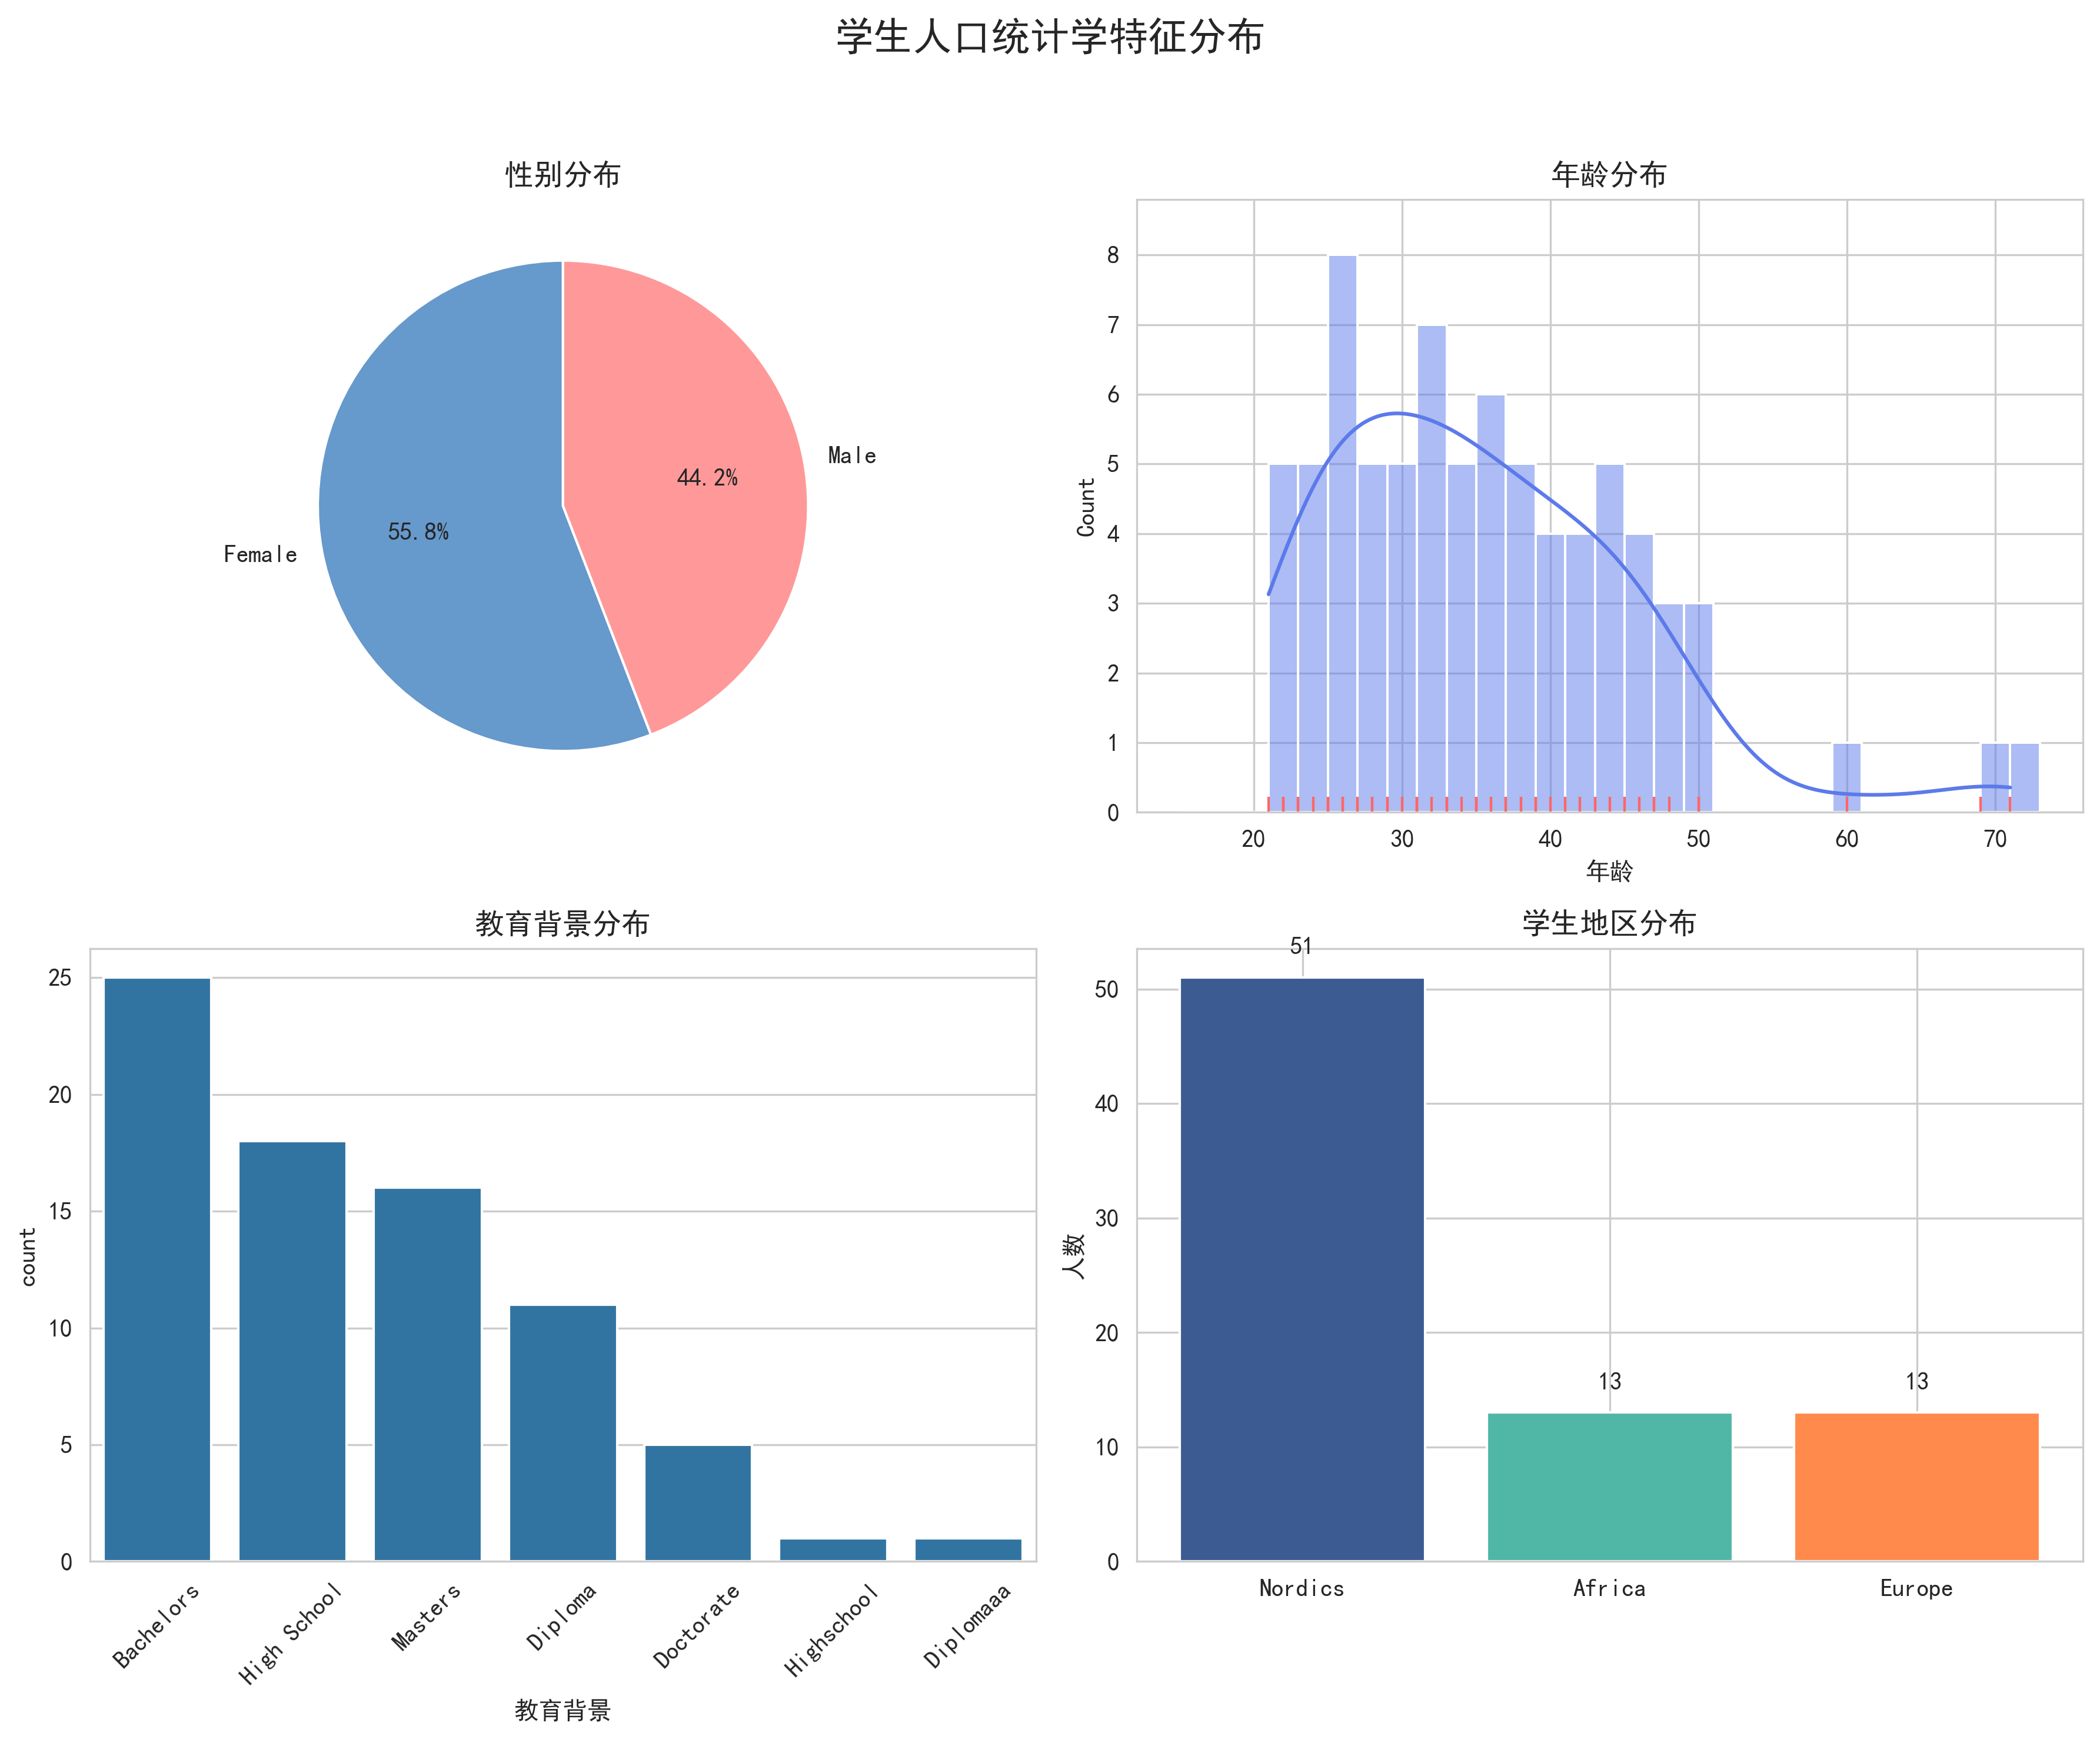

In [8]:
# 1. 学生人口统计学分析
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("学生人口统计学特征分布", fontsize=16, y=0.98)

# 性别统计
gender_counts = df['gender'].value_counts()
axes[0, 0].pie(
    gender_counts,
    labels=gender_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#6699CC', '#FF9999']
)
axes[0, 0].set_title('性别分布')

# 年龄统计
sns.histplot(df['Age'], bins=np.arange(15, 75, 2), kde=True, color='#5C7AEA', ax=axes[0, 1])
sns.rugplot(df['Age'], ax=axes[0, 1], color='#FF6666')
axes[0, 1].set_title('年龄分布')
axes[0, 1].set_xlabel('年龄')

# 学历分布
edu_order = df['prevEducation'].value_counts().index
sns.countplot(x = df['prevEducation'], data=df, order = edu_order, ax = axes[1, 0])
axes[1, 0].set_title('教育背景分布')
axes[1, 0].set_xlabel('教育背景')
axes[1, 0].tick_params(axis='x', rotation=45)

# 地区分布
region_counts = df['Region'].value_counts()
axes[1, 1].bar(region_counts.index, region_counts.values,
               color=['#3B5B92', '#50B6A6', '#FF8A4C', '#9397D8'])
for i,v in enumerate(region_counts.values):
    axes[1, 1].text(i, v + 2, str(v), ha='center')
axes[1, 1].set_title('学生地区分布')
axes[1, 1].set_ylabel('人数')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('./image/1.人口统计学分布.png')

In [1]:
# 成绩分布与分析
fig, axes = plt.subplots(3, 2, figsize=(14, 16))
fig.suptitle('📊 学生成绩分布与关系', fontsize=16, y=0.98)

# python平均成绩
sns.histplot(df['Python'], bins=15, kde=True, color='#5C7AEA', ax=axes[0, 0], alpha=0.8)
axes[0, 0].axvline(df['Python'].mean(), color='r', linestyle='--', label=f"平均分{df['Python'].mean():.1f}")
axes[0, 0].legend()
axes[0, 0].set_title('Python成绩分布')
axes[0, 0].set_xlabel('Python分数')
axes[0, 0].set_ylabel('频数')

# DB平均成绩
sns.boxplot(x='DB', data=df, ax=axes[0, 1], color='#2ecc71')
axes[0, 1].set_title('DB成绩分布')
axes[0, 1].set_xlabel('DB分数')

# python与DB成绩的关系
sns.scatterplot(x='Python', y='DB', data=df, ax=axes[1, 0],
                hue='gender', palette='Set1', alpha=0.7)
axes[1, 0].set_title('Python和DB成绩关系')
axes[1, 0].set_xlabel('Python分数')
axes[1, 0].set_ylabel('DB分数')

# 总分分布
sns.kdeplot(df['Total_Score'], fill=True, color='#8E349B', label='总分分布', ax=axes[1, 1])
sns.kdeplot(df['Python'], fill=True, color='#3498DB', label='Python', ax=axes[1, 1])
sns.kdeplot(df['DB'], fill=True, color='#2ECC71', label='DB', ax=axes[1, 1])
axes[1, 1].set_title('成绩分布对比')
axes[1, 1].set_xlabel('分数')
axes[1, 1].legend()

# 表现等级的分布
pref_count = df['Performance_Score'].value_counts(normalize=True)
axes[2, 0].bar(pref_count.index, pref_count.values,
               color=['#FF5252', '#4CAF50', '#2196F3', '#FFC107'])
for i,v in enumerate(pref_count.values):
    axes[2, 0].text(i, v + 0.05, f"{v*100:.1f}%", ha='center')
axes[2, 0].set_ylim(0, 0.5)
axes[2, 0].set_title('学生表现等级分布')
axes[2, 0].set_ylabel('比例')

# 学习时间和成绩的关系
sns.regplot(x='studyHOURS', y='Total_Score', data=df, ax=axes[2, 1],
            scatter_kws={'alpha': 0.6}, line_kws={'color':'red'})
axes[2, 1].set_title('学习时间与总分关系')
axes[2, 1].set_xlabel('每周学习时间（小时）')
axes[2, 1].set_ylabel('总成绩分数')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('./image/2.成绩分布与关系.png')

NameError: name 'plt' is not defined

In [1]:
# 不同分组下的成绩
fig, axes = plt.subplots(2, 2, figsize=(14, 16))
fig.suptitle('分组成绩对比分析', fontsize=16, y=0.98)

# 不同性别的成绩
sns.barplot(x='gender', y='Total_Score', data=df, ax=axes[0, 0],
            capsize=0.1, palette='pastel', errorbar='sd')
axes[0, 0].set_title('性别与总成绩')
axes[0, 0].set_xlabel('性别')
axes[0, 0].set_ylabel('平均总分')

# 地区成绩差异
sns.boxplot(x='Region', y='Total_Score', data=df,
            palette='Set3', showfliers=False, ax=axes[0, 1])
axes[0, 1].set_title('地区与总成绩分布')
axes[0, 1].set_xlabel('地区')
axes[0, 1].set_ylabel('总分')

# 教育背景与成绩
sns.barplot(x='prevEducation', y='Total_Score', data=df,
            palette='rocket', ax=axes[1, 0],
            capsize=0.1, errorbar='sd')
axes[1, 0].set_title('教育背景与总成绩')
axes[1, 0].set_xlabel('教育背景')
axes[1, 0].set_ylabel('平均总分')
axes[1, 0].tick_params(axis='x', rotation=45)

# 居住类型与成绩
residence_palette = {'BI Residence': '#3498db',
                     'Sognsvann': '#2ecc71',
                     'Private': '#9b59b6'}
sns.boxplot(x='residence', y='Total_Score', data=df,
            palette=residence_palette, ax=axes[1, 1])
axes[1, 1].set_title('居住类型与总成绩')
axes[1, 1].set_xlabel('居住类型')
axes[1, 1].set_ylabel('总分')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('./image/3.分组成绩对比.png')

NameError: name 'plt' is not defined

C:\Users\11963\AppData\Local\Temp\ipykernel_10424\2107145200.py:7: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) SimHei.
  plt.tight_layout()
C:\Users\11963\AppData\Local\Temp\ipykernel_10424\2107145200.py:8: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) SimHei.
  plt.savefig('./image/4.特征相关系数热力图.png')
F:\anaconda\envs\data_analysis\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


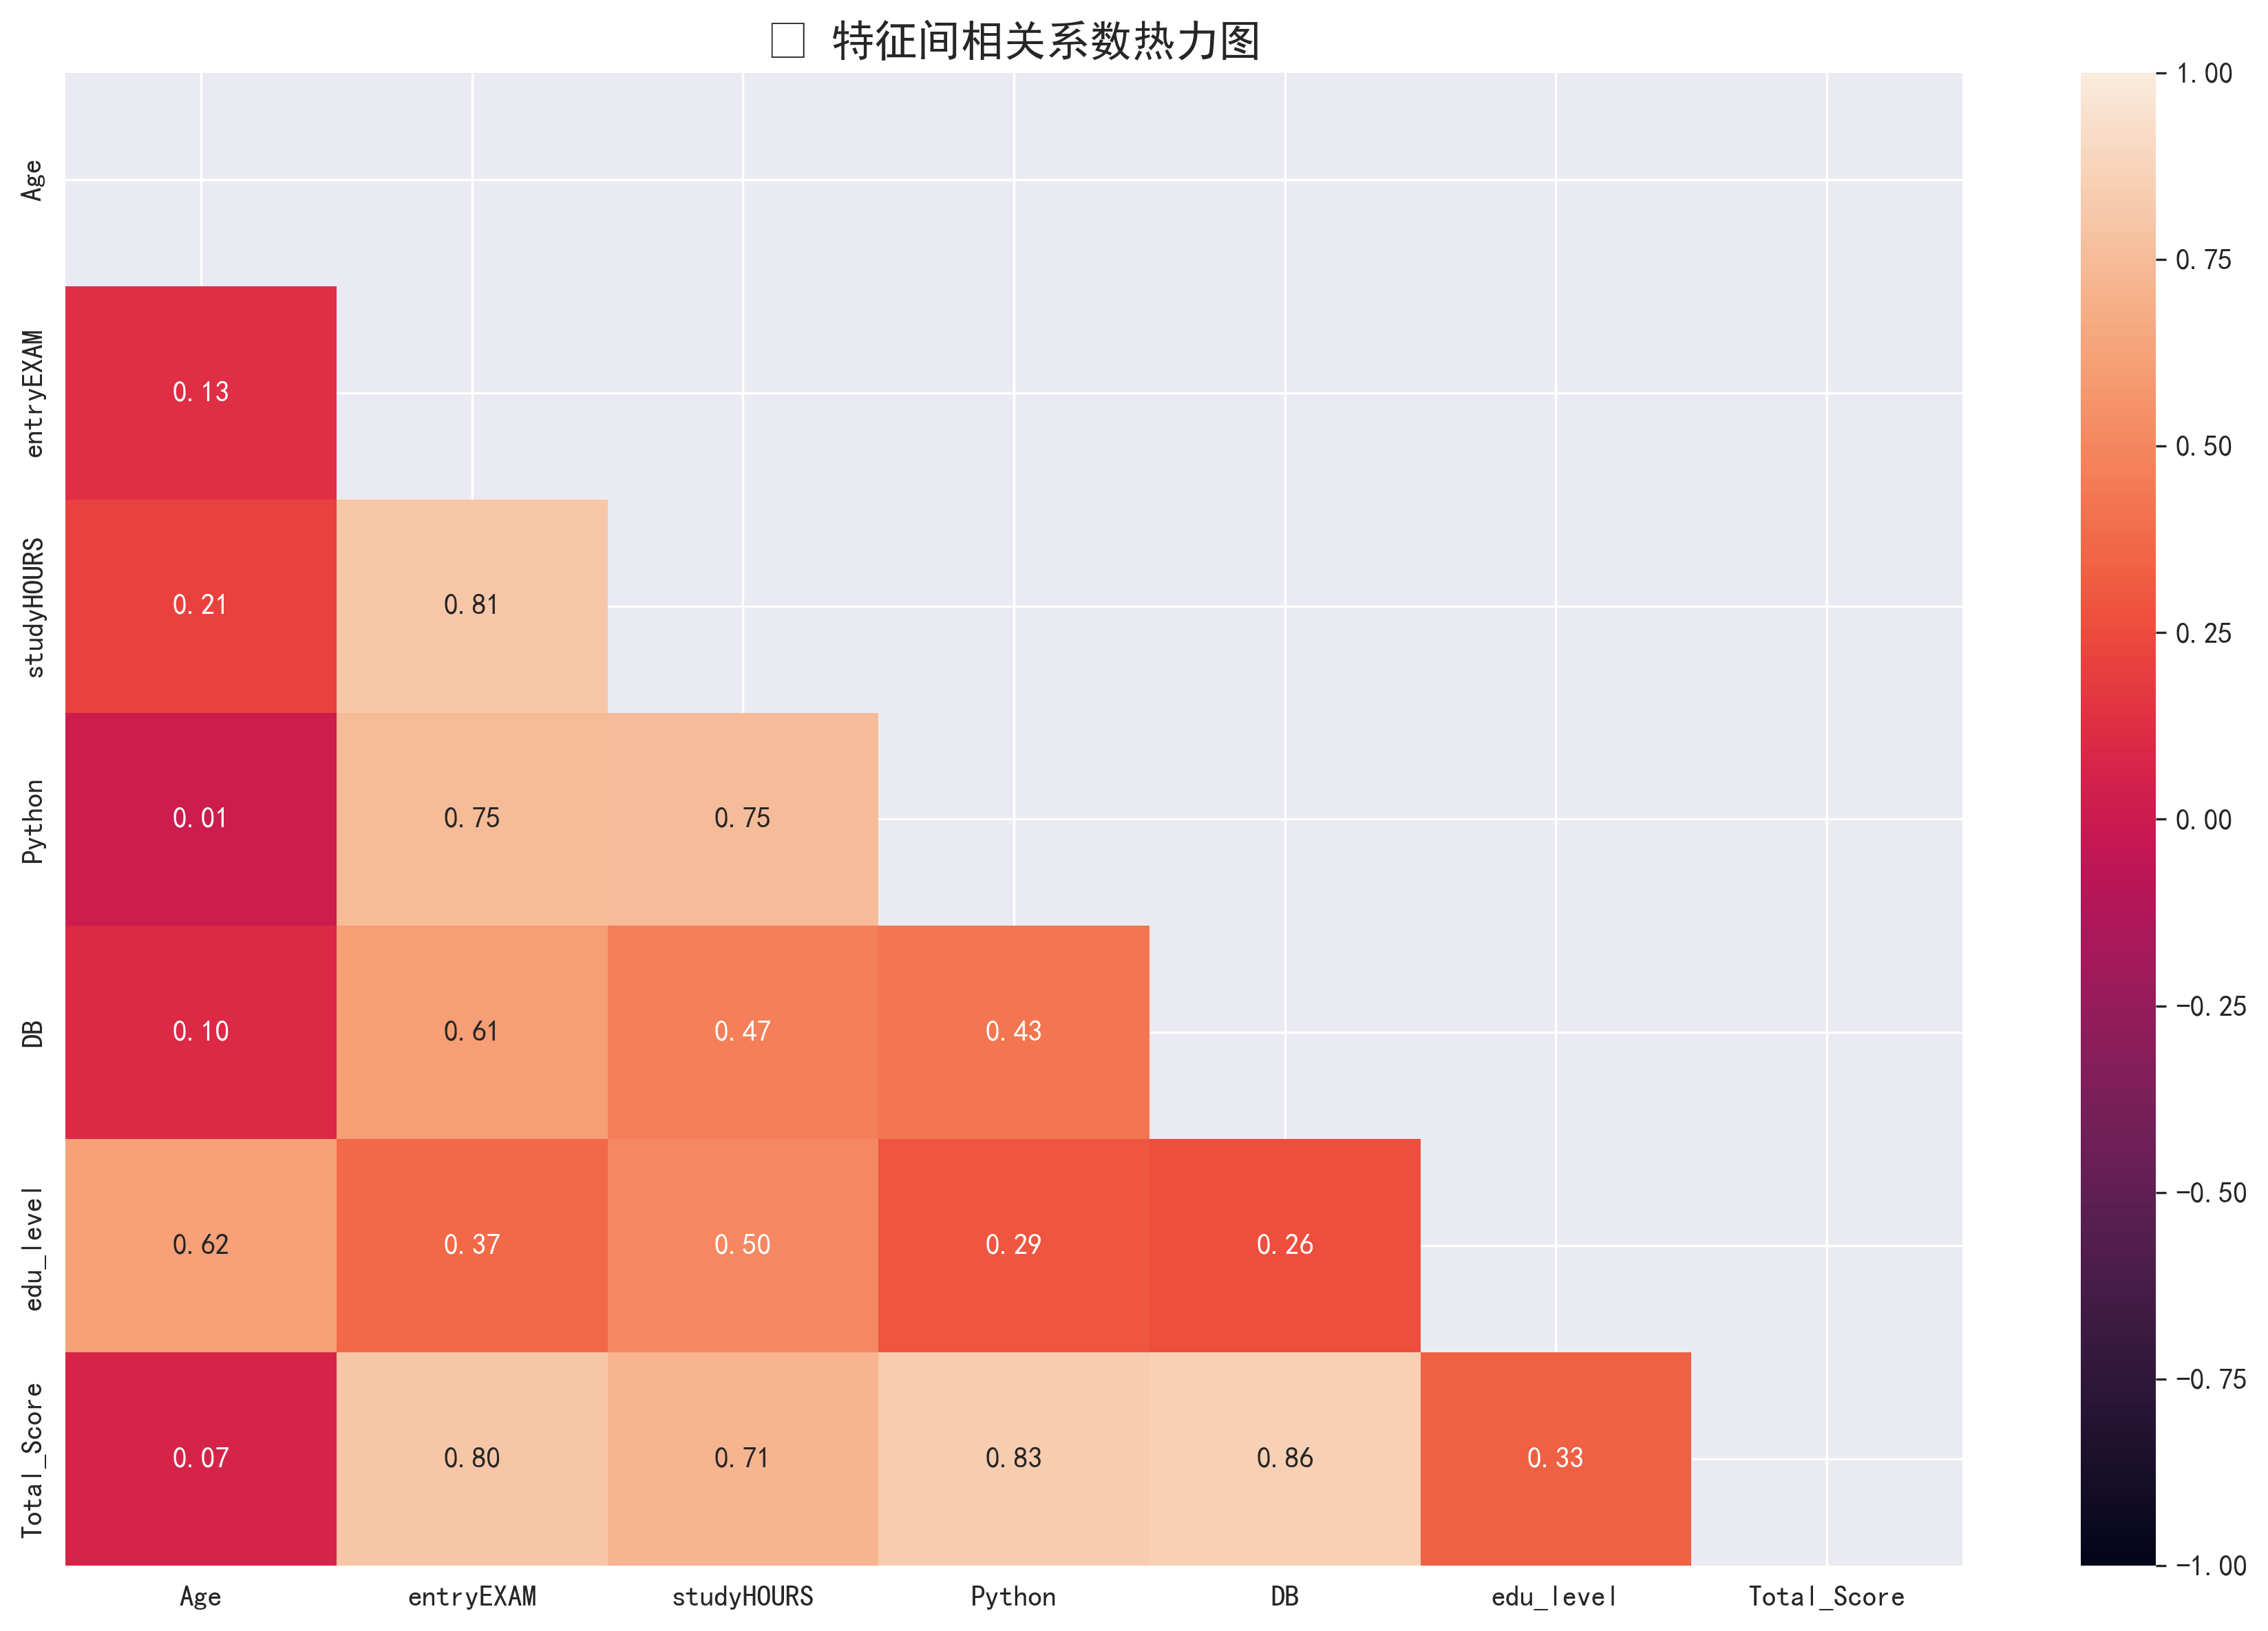

In [7]:
# 多变量交互分析
plt.figure(figsize=(12, 8))
corr = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, fmt='.2f', mask=mask, vmin=-1, vmax=1)
plt.title('📈 特征间相关系数热力图', fontsize=15)
plt.tight_layout()
plt.savefig('./image/4.特征相关系数热力图.png')
